<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:13:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


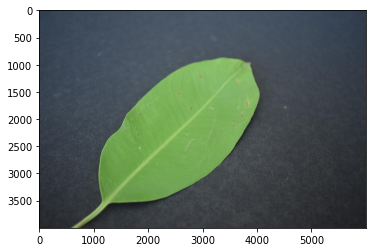

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

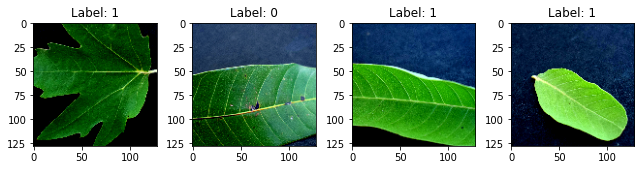

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:13:12] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:13:14] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2550461526676624 samples/sec                   batch loss = 0.5982698798179626 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2664716570508054 samples/sec                   batch loss = 1.2480599880218506 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2729965377550114 samples/sec                   batch loss = 0.26800301671028137 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2720663749729224 samples/sec                   batch loss = 0.8550430536270142 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2698065358054418 samples/sec                   batch loss = 0.5131440162658691 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2634610298419071 samples/sec                   batch loss = 1.29332435131073 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2648524958369043 samples/sec                   batch loss = 1.1438980102539062 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2605385511559284 samples/sec                   batch loss = 0.7941833734512329 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2691447034031809 samples/sec                   batch loss = 0.4504086673259735 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2742908131628286 samples/sec                   batch loss = 1.6595338582992554 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.270752548951974 samples/sec                   batch loss = 1.2136943340301514 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2680768539763716 samples/sec                   batch loss = 0.7104756832122803 | accuracy = 0.55


Epoch[1] Batch[65] Speed: 1.272939358729678 samples/sec                   batch loss = 0.5710319876670837 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2658604760093215 samples/sec                   batch loss = 0.47148051857948303 | accuracy = 0.5678571428571428


Epoch[1] Batch[75] Speed: 1.2573821441443374 samples/sec                   batch loss = 0.8331968784332275 | accuracy = 0.5733333333333334


Epoch[1] Batch[80] Speed: 1.2699714769153465 samples/sec                   batch loss = 1.0336774587631226 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2660611756928741 samples/sec                   batch loss = 1.3572804927825928 | accuracy = 0.5911764705882353


Epoch[1] Batch[90] Speed: 1.2554992208327123 samples/sec                   batch loss = 0.4930221140384674 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2586840352874131 samples/sec                   batch loss = 0.2956794798374176 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2711845708653733 samples/sec                   batch loss = 0.7102681994438171 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.2704920528061103 samples/sec                   batch loss = 1.6241174936294556 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2696083940035179 samples/sec                   batch loss = 0.707035481929779 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2720073506627476 samples/sec                   batch loss = 0.3918568789958954 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.2636185209127793 samples/sec                   batch loss = 0.5739330649375916 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.2711757098777499 samples/sec                   batch loss = 0.5855316519737244 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2656689106470527 samples/sec                   batch loss = 0.5687347650527954 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2671189325009744 samples/sec                   batch loss = 0.5366969704627991 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.2594069400934023 samples/sec                   batch loss = 0.41570383310317993 | accuracy = 0.6196428571428572


Epoch[1] Batch[145] Speed: 1.2612952584494306 samples/sec                   batch loss = 0.5903610587120056 | accuracy = 0.6189655172413793


Epoch[1] Batch[150] Speed: 1.2668134340146466 samples/sec                   batch loss = 0.4005049765110016 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2675789410378253 samples/sec                   batch loss = 0.93739253282547 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2674539733229946 samples/sec                   batch loss = 0.5465470552444458 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2650748158041756 samples/sec                   batch loss = 0.4329284429550171 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.2654412276605584 samples/sec                   batch loss = 0.5294049382209778 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2645463734773839 samples/sec                   batch loss = 0.720367968082428 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.2666017859632857 samples/sec                   batch loss = 0.26423966884613037 | accuracy = 0.6319444444444444


Epoch[1] Batch[185] Speed: 1.2811717748441187 samples/sec                   batch loss = 1.7147027254104614 | accuracy = 0.6297297297297297


Epoch[1] Batch[190] Speed: 1.2750254629422044 samples/sec                   batch loss = 2.109633684158325 | accuracy = 0.6328947368421053


Epoch[1] Batch[195] Speed: 1.2728720447378756 samples/sec                   batch loss = 0.5214046835899353 | accuracy = 0.6333333333333333


Epoch[1] Batch[200] Speed: 1.2821213811029037 samples/sec                   batch loss = 0.5694079399108887 | accuracy = 0.63


Epoch[1] Batch[205] Speed: 1.2706094408769417 samples/sec                   batch loss = 0.7014387249946594 | accuracy = 0.6317073170731707


Epoch[1] Batch[210] Speed: 1.2731524539646384 samples/sec                   batch loss = 0.8637153506278992 | accuracy = 0.6297619047619047


Epoch[1] Batch[215] Speed: 1.2716664285370491 samples/sec                   batch loss = 0.5595759153366089 | accuracy = 0.6302325581395349


Epoch[1] Batch[220] Speed: 1.274000905161547 samples/sec                   batch loss = 0.5418265461921692 | accuracy = 0.6272727272727273


Epoch[1] Batch[225] Speed: 1.2765166343337848 samples/sec                   batch loss = 0.6144306063652039 | accuracy = 0.6255555555555555


Epoch[1] Batch[230] Speed: 1.2817140108629155 samples/sec                   batch loss = 0.4231843650341034 | accuracy = 0.625


Epoch[1] Batch[235] Speed: 1.2671388385478053 samples/sec                   batch loss = 0.47822874784469604 | accuracy = 0.624468085106383


Epoch[1] Batch[240] Speed: 1.2680597937254485 samples/sec                   batch loss = 0.5444564819335938 | accuracy = 0.6260416666666667


Epoch[1] Batch[245] Speed: 1.2707165523602024 samples/sec                   batch loss = 0.4909791052341461 | accuracy = 0.6234693877551021


Epoch[1] Batch[250] Speed: 1.2742571321631515 samples/sec                   batch loss = 0.2771933674812317 | accuracy = 0.626


Epoch[1] Batch[255] Speed: 1.2724926313257 samples/sec                   batch loss = 0.8692492246627808 | accuracy = 0.6254901960784314


Epoch[1] Batch[260] Speed: 1.2701629046041734 samples/sec                   batch loss = 0.5718455910682678 | accuracy = 0.6278846153846154


Epoch[1] Batch[265] Speed: 1.2728179669177802 samples/sec                   batch loss = 0.42108654975891113 | accuracy = 0.629245283018868


Epoch[1] Batch[270] Speed: 1.2706246451809131 samples/sec                   batch loss = 0.43677759170532227 | accuracy = 0.6314814814814815


Epoch[1] Batch[275] Speed: 1.26948821298737 samples/sec                   batch loss = 0.7751142978668213 | accuracy = 0.63


Epoch[1] Batch[280] Speed: 1.2726029564787074 samples/sec                   batch loss = 0.3819867968559265 | accuracy = 0.6339285714285714


Epoch[1] Batch[285] Speed: 1.2737555154300697 samples/sec                   batch loss = 0.7876632213592529 | accuracy = 0.6359649122807017


Epoch[1] Batch[290] Speed: 1.2740062260490939 samples/sec                   batch loss = 1.0017845630645752 | accuracy = 0.6344827586206897


Epoch[1] Batch[295] Speed: 1.2730657969329502 samples/sec                   batch loss = 0.6595048904418945 | accuracy = 0.6389830508474577


Epoch[1] Batch[300] Speed: 1.2679415347192868 samples/sec                   batch loss = 1.9918245077133179 | accuracy = 0.6416666666666667


Epoch[1] Batch[305] Speed: 1.2708664232581393 samples/sec                   batch loss = 0.6929417848587036 | accuracy = 0.6426229508196721


Epoch[1] Batch[310] Speed: 1.2701035760408421 samples/sec                   batch loss = 1.868965983390808 | accuracy = 0.6419354838709678


Epoch[1] Batch[315] Speed: 1.2745520949463371 samples/sec                   batch loss = 1.1654459238052368 | accuracy = 0.6436507936507937


Epoch[1] Batch[320] Speed: 1.2753635351220272 samples/sec                   batch loss = 1.1544233560562134 | accuracy = 0.6453125


Epoch[1] Batch[325] Speed: 1.2715449902628813 samples/sec                   batch loss = 0.5880880355834961 | accuracy = 0.6461538461538462


Epoch[1] Batch[330] Speed: 1.2737934252089713 samples/sec                   batch loss = 0.37721389532089233 | accuracy = 0.6477272727272727


Epoch[1] Batch[335] Speed: 1.2711566399103649 samples/sec                   batch loss = 0.5162269473075867 | accuracy = 0.6492537313432836


Epoch[1] Batch[340] Speed: 1.2637120825348456 samples/sec                   batch loss = 0.5631078481674194 | accuracy = 0.6485294117647059


Epoch[1] Batch[345] Speed: 1.268241058399568 samples/sec                   batch loss = 0.8223780393600464 | accuracy = 0.6478260869565218


Epoch[1] Batch[350] Speed: 1.2568924986052397 samples/sec                   batch loss = 0.6551144123077393 | accuracy = 0.6478571428571429


Epoch[1] Batch[355] Speed: 1.260349350489349 samples/sec                   batch loss = 0.40838098526000977 | accuracy = 0.652112676056338


Epoch[1] Batch[360] Speed: 1.2566847170919055 samples/sec                   batch loss = 0.4186161756515503 | accuracy = 0.6527777777777778


Epoch[1] Batch[365] Speed: 1.2544724916499805 samples/sec                   batch loss = 0.44828253984451294 | accuracy = 0.6547945205479452


Epoch[1] Batch[370] Speed: 1.2592469999541402 samples/sec                   batch loss = 0.6475843191146851 | accuracy = 0.6554054054054054


Epoch[1] Batch[375] Speed: 1.2572571060302902 samples/sec                   batch loss = 1.1882742643356323 | accuracy = 0.656


Epoch[1] Batch[380] Speed: 1.270660925274936 samples/sec                   batch loss = 0.5356769561767578 | accuracy = 0.6572368421052631


Epoch[1] Batch[385] Speed: 1.2705868275535894 samples/sec                   batch loss = 0.5408087372779846 | accuracy = 0.6577922077922078


Epoch[1] Batch[390] Speed: 1.2686777057926109 samples/sec                   batch loss = 0.5265873670578003 | accuracy = 0.658974358974359


Epoch[1] Batch[395] Speed: 1.256329849247601 samples/sec                   batch loss = 0.36282363533973694 | accuracy = 0.6613924050632911


Epoch[1] Batch[400] Speed: 1.2706666032490233 samples/sec                   batch loss = 0.7344081997871399 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.2616247595615706 samples/sec                   batch loss = 0.3577861785888672 | accuracy = 0.6635802469135802


Epoch[1] Batch[410] Speed: 1.2580643081020337 samples/sec                   batch loss = 0.588810920715332 | accuracy = 0.6628048780487805


Epoch[1] Batch[415] Speed: 1.2511415205025502 samples/sec                   batch loss = 0.4889189898967743 | accuracy = 0.6632530120481928


Epoch[1] Batch[420] Speed: 1.2518329001805013 samples/sec                   batch loss = 0.5012863278388977 | accuracy = 0.6619047619047619


Epoch[1] Batch[425] Speed: 1.258014688371496 samples/sec                   batch loss = 0.620689868927002 | accuracy = 0.6623529411764706


Epoch[1] Batch[430] Speed: 1.2532204819469703 samples/sec                   batch loss = 0.4052318334579468 | accuracy = 0.6616279069767442


Epoch[1] Batch[435] Speed: 1.2564445406363995 samples/sec                   batch loss = 0.6912950277328491 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.2508679243032226 samples/sec                   batch loss = 0.4198145568370819 | accuracy = 0.6642045454545454


Epoch[1] Batch[445] Speed: 1.2556853703273625 samples/sec                   batch loss = 1.595340609550476 | accuracy = 0.6646067415730337


Epoch[1] Batch[450] Speed: 1.2560963913729444 samples/sec                   batch loss = 0.35152265429496765 | accuracy = 0.6655555555555556


Epoch[1] Batch[455] Speed: 1.2561823524712301 samples/sec                   batch loss = 0.5116626620292664 | accuracy = 0.667032967032967


Epoch[1] Batch[460] Speed: 1.2693779469890019 samples/sec                   batch loss = 0.9376550912857056 | accuracy = 0.6668478260869565


Epoch[1] Batch[465] Speed: 1.2663770172551743 samples/sec                   batch loss = 0.4491855502128601 | accuracy = 0.6672043010752688


Epoch[1] Batch[470] Speed: 1.2655303818047783 samples/sec                   batch loss = 0.3169216215610504 | accuracy = 0.6680851063829787


Epoch[1] Batch[475] Speed: 1.266862889323882 samples/sec                   batch loss = 0.3037574887275696 | accuracy = 0.6689473684210526


Epoch[1] Batch[480] Speed: 1.2700525213741856 samples/sec                   batch loss = 0.4521803855895996 | accuracy = 0.66875


Epoch[1] Batch[485] Speed: 1.271423286124227 samples/sec                   batch loss = 0.4236064553260803 | accuracy = 0.6695876288659793


Epoch[1] Batch[490] Speed: 1.2636251830319851 samples/sec                   batch loss = 1.261709451675415 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.267227083459693 samples/sec                   batch loss = 0.7423397302627563 | accuracy = 0.6707070707070707


Epoch[1] Batch[500] Speed: 1.260017013803381 samples/sec                   batch loss = 0.41155004501342773 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.261778282004605 samples/sec                   batch loss = 0.46023550629615784 | accuracy = 0.6727722772277228


Epoch[1] Batch[510] Speed: 1.2655212176304138 samples/sec                   batch loss = 0.4045945107936859 | accuracy = 0.6730392156862746


Epoch[1] Batch[515] Speed: 1.2626306405512124 samples/sec                   batch loss = 0.4030786454677582 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.2626281699352062 samples/sec                   batch loss = 0.5980450510978699 | accuracy = 0.6745192307692308


Epoch[1] Batch[525] Speed: 1.263904579408527 samples/sec                   batch loss = 0.2977031469345093 | accuracy = 0.6757142857142857


Epoch[1] Batch[530] Speed: 1.2673723027609731 samples/sec                   batch loss = 1.1684664487838745 | accuracy = 0.6754716981132075


Epoch[1] Batch[535] Speed: 1.263410317509744 samples/sec                   batch loss = 0.3656088709831238 | accuracy = 0.6761682242990654


Epoch[1] Batch[540] Speed: 1.2627019124829464 samples/sec                   batch loss = 0.3775148093700409 | accuracy = 0.675


Epoch[1] Batch[545] Speed: 1.2638586870954585 samples/sec                   batch loss = 0.3147221803665161 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.263573315530914 samples/sec                   batch loss = 0.38195329904556274 | accuracy = 0.6772727272727272


Epoch[1] Batch[555] Speed: 1.2639894223144714 samples/sec                   batch loss = 0.6095761656761169 | accuracy = 0.6779279279279279


Epoch[1] Batch[560] Speed: 1.2622518939929712 samples/sec                   batch loss = 0.3418416976928711 | accuracy = 0.6785714285714286


Epoch[1] Batch[565] Speed: 1.2639868511499668 samples/sec                   batch loss = 0.579710841178894 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.2637134151503857 samples/sec                   batch loss = 0.5767740607261658 | accuracy = 0.6793859649122806


Epoch[1] Batch[575] Speed: 1.273816152816489 samples/sec                   batch loss = 0.4259459674358368 | accuracy = 0.6808695652173913


Epoch[1] Batch[580] Speed: 1.2722758011510926 samples/sec                   batch loss = 0.484018474817276 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.2717619570009455 samples/sec                   batch loss = 0.2839631140232086 | accuracy = 0.6824786324786325


Epoch[1] Batch[590] Speed: 1.2661624571854002 samples/sec                   batch loss = 0.3511163592338562 | accuracy = 0.684322033898305


Epoch[1] Batch[595] Speed: 1.265833351566974 samples/sec                   batch loss = 0.39475488662719727 | accuracy = 0.6852941176470588


Epoch[1] Batch[600] Speed: 1.2706947051559685 samples/sec                   batch loss = 0.3849963843822479 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.2631535834039551 samples/sec                   batch loss = 0.6692721247673035 | accuracy = 0.6867768595041323


Epoch[1] Batch[610] Speed: 1.2691103338684704 samples/sec                   batch loss = 0.2659696340560913 | accuracy = 0.6885245901639344


Epoch[1] Batch[615] Speed: 1.2642283958152671 samples/sec                   batch loss = 0.27837640047073364 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2691845475120687 samples/sec                   batch loss = 0.8281619548797607 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.2574339758228321 samples/sec                   batch loss = 0.4844859838485718 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.2499285530160462 samples/sec                   batch loss = 0.3973439633846283 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.255512844239162 samples/sec                   batch loss = 0.6792595386505127 | accuracy = 0.6913385826771653


Epoch[1] Batch[640] Speed: 1.249638825734497 samples/sec                   batch loss = 0.11544196307659149 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2492402048676925 samples/sec                   batch loss = 0.37420642375946045 | accuracy = 0.6922480620155039


Epoch[1] Batch[650] Speed: 1.252895449136363 samples/sec                   batch loss = 0.7732177972793579 | accuracy = 0.6926923076923077


Epoch[1] Batch[655] Speed: 1.2735633901051235 samples/sec                   batch loss = 0.3554357886314392 | accuracy = 0.6931297709923664


Epoch[1] Batch[660] Speed: 1.2619185533335935 samples/sec                   batch loss = 0.316152960062027 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.2628229981818504 samples/sec                   batch loss = 0.2899513244628906 | accuracy = 0.6951127819548872


Epoch[1] Batch[670] Speed: 1.2571048701340546 samples/sec                   batch loss = 0.6852870583534241 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.2563608957108074 samples/sec                   batch loss = 0.35089460015296936 | accuracy = 0.6955555555555556


Epoch[1] Batch[680] Speed: 1.253454182980587 samples/sec                   batch loss = 0.6806506514549255 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.248388266447287 samples/sec                   batch loss = 0.9197241067886353 | accuracy = 0.6930656934306569


Epoch[1] Batch[690] Speed: 1.2437169823783207 samples/sec                   batch loss = 0.9076285362243652 | accuracy = 0.6923913043478261


Epoch[1] Batch[695] Speed: 1.2483460019066106 samples/sec                   batch loss = 0.4102831184864044 | accuracy = 0.6931654676258993


Epoch[1] Batch[700] Speed: 1.2499828452736066 samples/sec                   batch loss = 2.390639066696167 | accuracy = 0.6928571428571428


Epoch[1] Batch[705] Speed: 1.248471317639325 samples/sec                   batch loss = 0.23476877808570862 | accuracy = 0.6925531914893617


Epoch[1] Batch[710] Speed: 1.246414459380539 samples/sec                   batch loss = 1.0987980365753174 | accuracy = 0.6911971830985916


Epoch[1] Batch[715] Speed: 1.2518855831453017 samples/sec                   batch loss = 0.16651815176010132 | accuracy = 0.6926573426573427


Epoch[1] Batch[720] Speed: 1.2554891678878786 samples/sec                   batch loss = 0.5830475687980652 | accuracy = 0.6927083333333334


Epoch[1] Batch[725] Speed: 1.2518613895310904 samples/sec                   batch loss = 0.4911729395389557 | accuracy = 0.6924137931034483


Epoch[1] Batch[730] Speed: 1.258480664264005 samples/sec                   batch loss = 0.6312645673751831 | accuracy = 0.6924657534246575


Epoch[1] Batch[735] Speed: 1.2649580666182565 samples/sec                   batch loss = 0.2955154478549957 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2630610553459347 samples/sec                   batch loss = 0.4163784086704254 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.2600416183151228 samples/sec                   batch loss = 0.6148074865341187 | accuracy = 0.6916107382550336


Epoch[1] Batch[750] Speed: 1.2581741268974922 samples/sec                   batch loss = 0.6006962060928345 | accuracy = 0.6913333333333334


Epoch[1] Batch[755] Speed: 1.2560089375597836 samples/sec                   batch loss = 0.6922467947006226 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.2635772173415964 samples/sec                   batch loss = 0.5096481442451477 | accuracy = 0.6904605263157895


Epoch[1] Batch[765] Speed: 1.2647103321440722 samples/sec                   batch loss = 0.8856651186943054 | accuracy = 0.6905228758169935


Epoch[1] Batch[770] Speed: 1.2581872422791067 samples/sec                   batch loss = 0.34018662571907043 | accuracy = 0.6912337662337662


Epoch[1] Batch[775] Speed: 1.2628308876163477 samples/sec                   batch loss = 0.44470110535621643 | accuracy = 0.6909677419354838


Epoch[1] Batch[780] Speed: 1.2666466345246419 samples/sec                   batch loss = 1.3181036710739136 | accuracy = 0.6916666666666667


Epoch[1] Batch[785] Speed: 1.262691078630766 samples/sec                   batch loss = 0.3059670925140381 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6919416243654822
[Epoch 1] time cost: 650.7575001716614
[Epoch 1] validation: validation accuracy=0.6944444444444444


Epoch[2] Batch[5] Speed: 1.271215392654035 samples/sec                   batch loss = 0.5826468467712402 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2749334158504624 samples/sec                   batch loss = 1.0504916906356812 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2599440576119783 samples/sec                   batch loss = 0.6022447347640991 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.26417333532058 samples/sec                   batch loss = 0.5622936487197876 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2630550647878604 samples/sec                   batch loss = 0.3633878827095032 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.2695850477089041 samples/sec                   batch loss = 1.207274079322815 | accuracy = 0.8


Epoch[2] Batch[35] Speed: 1.2710893217219223 samples/sec                   batch loss = 0.7385949492454529 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2738358829716978 samples/sec                   batch loss = 0.9330336451530457 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2818987107521471 samples/sec                   batch loss = 0.682056725025177 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.267748668454101 samples/sec                   batch loss = 0.6261768341064453 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2712449637123604 samples/sec                   batch loss = 0.21967852115631104 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2735082868440857 samples/sec                   batch loss = 0.708420991897583 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2704308656583416 samples/sec                   batch loss = 0.725204586982727 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.2731774775322393 samples/sec                   batch loss = 0.5102961659431458 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.271430512560188 samples/sec                   batch loss = 0.6302886605262756 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2740126111728185 samples/sec                   batch loss = 0.6016154289245605 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.271936760151842 samples/sec                   batch loss = 0.47476914525032043 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2688934071410316 samples/sec                   batch loss = 0.49582546949386597 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2727556865509455 samples/sec                   batch loss = 0.3518206775188446 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.272706542470961 samples/sec                   batch loss = 0.3866364359855652 | accuracy = 0.765


Epoch[2] Batch[105] Speed: 1.279017844039897 samples/sec                   batch loss = 0.3248959481716156 | accuracy = 0.7642857142857142


Epoch[2] Batch[110] Speed: 1.2705698921449469 samples/sec                   batch loss = 0.11469001322984695 | accuracy = 0.7659090909090909


Epoch[2] Batch[115] Speed: 1.2730855038502809 samples/sec                   batch loss = 0.37194791436195374 | accuracy = 0.7652173913043478


Epoch[2] Batch[120] Speed: 1.2760868047310365 samples/sec                   batch loss = 0.3310911953449249 | accuracy = 0.7645833333333333


Epoch[2] Batch[125] Speed: 1.2733577922353423 samples/sec                   batch loss = 1.1000663042068481 | accuracy = 0.762


Epoch[2] Batch[130] Speed: 1.271491506952302 samples/sec                   batch loss = 0.341062992811203 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.276680020256771 samples/sec                   batch loss = 0.3109241724014282 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2770494926615699 samples/sec                   batch loss = 0.8327656388282776 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2643199516494463 samples/sec                   batch loss = 0.1790335327386856 | accuracy = 0.7620689655172413


Epoch[2] Batch[150] Speed: 1.266606758355122 samples/sec                   batch loss = 0.2530527710914612 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2629291811247625 samples/sec                   batch loss = 0.14707797765731812 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.2624402414144145 samples/sec                   batch loss = 0.3287619650363922 | accuracy = 0.765625


Epoch[2] Batch[165] Speed: 1.2526326823838674 samples/sec                   batch loss = 0.1920822411775589 | accuracy = 0.7666666666666667


Epoch[2] Batch[170] Speed: 1.2620131924077085 samples/sec                   batch loss = 0.4927055835723877 | accuracy = 0.7676470588235295


Epoch[2] Batch[175] Speed: 1.2614716538705297 samples/sec                   batch loss = 0.7551310062408447 | accuracy = 0.7657142857142857


Epoch[2] Batch[180] Speed: 1.267733437106247 samples/sec                   batch loss = 0.6708788871765137 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2664608540155622 samples/sec                   batch loss = 0.5885512828826904 | accuracy = 0.7621621621621621


Epoch[2] Batch[190] Speed: 1.2634466625202474 samples/sec                   batch loss = 0.44251883029937744 | accuracy = 0.7631578947368421


Epoch[2] Batch[195] Speed: 1.2645594314176225 samples/sec                   batch loss = 0.5370296835899353 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2520687937158703 samples/sec                   batch loss = 0.5774604082107544 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.2524782916884873 samples/sec                   batch loss = 0.29415348172187805 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.2552176113958555 samples/sec                   batch loss = 0.7627876996994019 | accuracy = 0.763095238095238


Epoch[2] Batch[215] Speed: 1.2518907209057613 samples/sec                   batch loss = 0.3178179860115051 | accuracy = 0.7662790697674419


Epoch[2] Batch[220] Speed: 1.256605934366273 samples/sec                   batch loss = 0.35098397731781006 | accuracy = 0.7647727272727273


Epoch[2] Batch[225] Speed: 1.251882687335262 samples/sec                   batch loss = 0.18549028038978577 | accuracy = 0.7666666666666667


Epoch[2] Batch[230] Speed: 1.2581428964060861 samples/sec                   batch loss = 0.3317020833492279 | accuracy = 0.7652173913043478


Epoch[2] Batch[235] Speed: 1.2629130196322973 samples/sec                   batch loss = 0.19735649228096008 | accuracy = 0.7627659574468085


Epoch[2] Batch[240] Speed: 1.262536478910336 samples/sec                   batch loss = 0.44780242443084717 | accuracy = 0.765625


Epoch[2] Batch[245] Speed: 1.2727088595918357 samples/sec                   batch loss = 0.39179855585098267 | accuracy = 0.7693877551020408


Epoch[2] Batch[250] Speed: 1.2664460359926621 samples/sec                   batch loss = 0.6911568641662598 | accuracy = 0.769


Epoch[2] Batch[255] Speed: 1.2723307978049183 samples/sec                   batch loss = 0.8917016983032227 | accuracy = 0.7705882352941177


Epoch[2] Batch[260] Speed: 1.2681087712965005 samples/sec                   batch loss = 1.7521687746047974 | accuracy = 0.7721153846153846


Epoch[2] Batch[265] Speed: 1.2651576215885882 samples/sec                   batch loss = 0.13483133912086487 | accuracy = 0.7716981132075472


Epoch[2] Batch[270] Speed: 1.2710260549031944 samples/sec                   batch loss = 0.19077514111995697 | accuracy = 0.774074074074074


Epoch[2] Batch[275] Speed: 1.2676335323702153 samples/sec                   batch loss = 0.6856614351272583 | accuracy = 0.7736363636363637


Epoch[2] Batch[280] Speed: 1.2708092429067912 samples/sec                   batch loss = 0.5768187642097473 | accuracy = 0.7705357142857143


Epoch[2] Batch[285] Speed: 1.2699942606112458 samples/sec                   batch loss = 0.8276680707931519 | accuracy = 0.7684210526315789


Epoch[2] Batch[290] Speed: 1.267859992938707 samples/sec                   batch loss = 0.525201141834259 | accuracy = 0.7672413793103449


Epoch[2] Batch[295] Speed: 1.267934060417939 samples/sec                   batch loss = 0.5114220380783081 | accuracy = 0.7669491525423728


Epoch[2] Batch[300] Speed: 1.2625390441776116 samples/sec                   batch loss = 0.23744982481002808 | accuracy = 0.7683333333333333


Epoch[2] Batch[305] Speed: 1.25997670233413 samples/sec                   batch loss = 0.2963937819004059 | accuracy = 0.7704918032786885


Epoch[2] Batch[310] Speed: 1.266077608946964 samples/sec                   batch loss = 0.47765806317329407 | accuracy = 0.7701612903225806


Epoch[2] Batch[315] Speed: 1.2637978515939112 samples/sec                   batch loss = 0.10966482758522034 | accuracy = 0.7706349206349207


Epoch[2] Batch[320] Speed: 1.2665657372900025 samples/sec                   batch loss = 0.253721684217453 | accuracy = 0.77109375


Epoch[2] Batch[325] Speed: 1.2720471818266323 samples/sec                   batch loss = 0.5562341809272766 | accuracy = 0.77


Epoch[2] Batch[330] Speed: 1.2657713708488842 samples/sec                   batch loss = 0.8024530410766602 | accuracy = 0.7712121212121212


Epoch[2] Batch[335] Speed: 1.2697629047066448 samples/sec                   batch loss = 0.21684083342552185 | accuracy = 0.7716417910447761


Epoch[2] Batch[340] Speed: 1.2699451372899975 samples/sec                   batch loss = 0.8954612612724304 | accuracy = 0.7735294117647059


Epoch[2] Batch[345] Speed: 1.2713722216513486 samples/sec                   batch loss = 0.5522770285606384 | accuracy = 0.7746376811594203


Epoch[2] Batch[350] Speed: 1.2787115521645023 samples/sec                   batch loss = 0.6792770028114319 | accuracy = 0.775


Epoch[2] Batch[355] Speed: 1.2693994608015824 samples/sec                   batch loss = 0.2878051996231079 | accuracy = 0.7746478873239436


Epoch[2] Batch[360] Speed: 1.2708681560763866 samples/sec                   batch loss = 1.0214576721191406 | accuracy = 0.7763888888888889


Epoch[2] Batch[365] Speed: 1.269779818609327 samples/sec                   batch loss = 0.35764390230178833 | accuracy = 0.7760273972602739


Epoch[2] Batch[370] Speed: 1.2681862230049965 samples/sec                   batch loss = 0.28346163034439087 | accuracy = 0.7743243243243243


Epoch[2] Batch[375] Speed: 1.26608792771989 samples/sec                   batch loss = 0.7680270075798035 | accuracy = 0.7726666666666666


Epoch[2] Batch[380] Speed: 1.267399397454794 samples/sec                   batch loss = 0.585703432559967 | accuracy = 0.7710526315789473


Epoch[2] Batch[385] Speed: 1.26924042948903 samples/sec                   batch loss = 0.5282047986984253 | accuracy = 0.7688311688311689


Epoch[2] Batch[390] Speed: 1.270847651363339 samples/sec                   batch loss = 0.5767842531204224 | accuracy = 0.7692307692307693


Epoch[2] Batch[395] Speed: 1.2622287224998383 samples/sec                   batch loss = 0.3769427239894867 | accuracy = 0.7708860759493671


Epoch[2] Batch[400] Speed: 1.2680418713720085 samples/sec                   batch loss = 0.7238574624061584 | accuracy = 0.771875


Epoch[2] Batch[405] Speed: 1.2649965990977525 samples/sec                   batch loss = 0.32420122623443604 | accuracy = 0.7722222222222223


Epoch[2] Batch[410] Speed: 1.267446026018231 samples/sec                   batch loss = 0.5849337577819824 | accuracy = 0.7707317073170732


Epoch[2] Batch[415] Speed: 1.267403035699784 samples/sec                   batch loss = 0.3463480472564697 | accuracy = 0.7710843373493976


Epoch[2] Batch[420] Speed: 1.2599916532354152 samples/sec                   batch loss = 0.6237025260925293 | accuracy = 0.7702380952380953


Epoch[2] Batch[425] Speed: 1.2633133759949302 samples/sec                   batch loss = 0.5925776958465576 | accuracy = 0.7688235294117647


Epoch[2] Batch[430] Speed: 1.264603658853717 samples/sec                   batch loss = 0.5224482417106628 | accuracy = 0.7691860465116279


Epoch[2] Batch[435] Speed: 1.2552064360429418 samples/sec                   batch loss = 0.5299509167671204 | accuracy = 0.7689655172413793


Epoch[2] Batch[440] Speed: 1.2617709750836343 samples/sec                   batch loss = 0.43260785937309265 | accuracy = 0.7681818181818182


Epoch[2] Batch[445] Speed: 1.261945795022385 samples/sec                   batch loss = 0.6621025204658508 | accuracy = 0.7679775280898876


Epoch[2] Batch[450] Speed: 1.2725412762794366 samples/sec                   batch loss = 0.40037810802459717 | accuracy = 0.7677777777777778


Epoch[2] Batch[455] Speed: 1.2774488448362402 samples/sec                   batch loss = 0.6068139672279358 | accuracy = 0.7664835164835165


Epoch[2] Batch[460] Speed: 1.2703743016514426 samples/sec                   batch loss = 0.40631240606307983 | accuracy = 0.7673913043478261


Epoch[2] Batch[465] Speed: 1.2708028898520383 samples/sec                   batch loss = 0.0679362565279007 | accuracy = 0.7655913978494624


Epoch[2] Batch[470] Speed: 1.2653905471255935 samples/sec                   batch loss = 0.9198565483093262 | accuracy = 0.7664893617021277


Epoch[2] Batch[475] Speed: 1.2665398255855869 samples/sec                   batch loss = 0.7449035048484802 | accuracy = 0.7668421052631579


Epoch[2] Batch[480] Speed: 1.2569393931061992 samples/sec                   batch loss = 0.334808349609375 | accuracy = 0.7671875


Epoch[2] Batch[485] Speed: 1.2621675690380296 samples/sec                   batch loss = 0.39838123321533203 | accuracy = 0.7670103092783506


Epoch[2] Batch[490] Speed: 1.259077651377992 samples/sec                   batch loss = 0.3543526232242584 | accuracy = 0.7678571428571429


Epoch[2] Batch[495] Speed: 1.2591248035762077 samples/sec                   batch loss = 0.8774791359901428 | accuracy = 0.7671717171717172


Epoch[2] Batch[500] Speed: 1.2632672412449448 samples/sec                   batch loss = 0.5355673432350159 | accuracy = 0.765


Epoch[2] Batch[505] Speed: 1.2515265114764929 samples/sec                   batch loss = 0.07282815873622894 | accuracy = 0.7648514851485149


Epoch[2] Batch[510] Speed: 1.2625281181115706 samples/sec                   batch loss = 0.537615180015564 | accuracy = 0.7647058823529411


Epoch[2] Batch[515] Speed: 1.2630455560822047 samples/sec                   batch loss = 0.11909100413322449 | accuracy = 0.7645631067961165


Epoch[2] Batch[520] Speed: 1.2700049317372621 samples/sec                   batch loss = 0.5013911724090576 | accuracy = 0.7629807692307692


Epoch[2] Batch[525] Speed: 1.2757536845401434 samples/sec                   batch loss = 0.3397403359413147 | accuracy = 0.7633333333333333


Epoch[2] Batch[530] Speed: 1.2772892490356123 samples/sec                   batch loss = 0.511810302734375 | accuracy = 0.7627358490566037


Epoch[2] Batch[535] Speed: 1.2732374801317707 samples/sec                   batch loss = 0.3627290427684784 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2759501588053421 samples/sec                   batch loss = 1.2996606826782227 | accuracy = 0.7625


Epoch[2] Batch[545] Speed: 1.2767314148440165 samples/sec                   batch loss = 0.17052365839481354 | accuracy = 0.763302752293578


Epoch[2] Batch[550] Speed: 1.2651946396617162 samples/sec                   batch loss = 0.5923429131507874 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2728172909741065 samples/sec                   batch loss = 0.1838667392730713 | accuracy = 0.7626126126126126


Epoch[2] Batch[560] Speed: 1.2674873913938889 samples/sec                   batch loss = 0.6156792640686035 | accuracy = 0.7611607142857143


Epoch[2] Batch[565] Speed: 1.2727643764687961 samples/sec                   batch loss = 0.23630350828170776 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.2712459269621523 samples/sec                   batch loss = 0.7598321437835693 | accuracy = 0.7614035087719299


Epoch[2] Batch[575] Speed: 1.2628570280133566 samples/sec                   batch loss = 0.15609882771968842 | accuracy = 0.7613043478260869


Epoch[2] Batch[580] Speed: 1.2665804624948438 samples/sec                   batch loss = 0.25980767607688904 | accuracy = 0.7620689655172413


Epoch[2] Batch[585] Speed: 1.2656134381869666 samples/sec                   batch loss = 0.7394758462905884 | accuracy = 0.7611111111111111


Epoch[2] Batch[590] Speed: 1.2670298414650927 samples/sec                   batch loss = 0.3185194432735443 | accuracy = 0.7610169491525424


Epoch[2] Batch[595] Speed: 1.2647635325204083 samples/sec                   batch loss = 0.5330298542976379 | accuracy = 0.7621848739495798


Epoch[2] Batch[600] Speed: 1.2677342992482403 samples/sec                   batch loss = 0.5877365469932556 | accuracy = 0.76125


Epoch[2] Batch[605] Speed: 1.2693948506374964 samples/sec                   batch loss = 0.2612230181694031 | accuracy = 0.7619834710743801


Epoch[2] Batch[610] Speed: 1.267910392378337 samples/sec                   batch loss = 0.3384852707386017 | accuracy = 0.7622950819672131


Epoch[2] Batch[615] Speed: 1.2670914670112599 samples/sec                   batch loss = 0.44375911355018616 | accuracy = 0.760569105691057


Epoch[2] Batch[620] Speed: 1.2654506770228584 samples/sec                   batch loss = 0.3127022087574005 | accuracy = 0.7608870967741935


Epoch[2] Batch[625] Speed: 1.2683852636048198 samples/sec                   batch loss = 0.5919192433357239 | accuracy = 0.7608


Epoch[2] Batch[630] Speed: 1.269737150311194 samples/sec                   batch loss = 0.6302261352539062 | accuracy = 0.7603174603174603


Epoch[2] Batch[635] Speed: 1.2657089187611226 samples/sec                   batch loss = 0.4448794424533844 | accuracy = 0.761023622047244


Epoch[2] Batch[640] Speed: 1.268943120963885 samples/sec                   batch loss = 0.41351044178009033 | accuracy = 0.7609375


Epoch[2] Batch[645] Speed: 1.2741581319473743 samples/sec                   batch loss = 0.9287760257720947 | accuracy = 0.7604651162790698


Epoch[2] Batch[650] Speed: 1.2658512115444265 samples/sec                   batch loss = 0.4731467366218567 | accuracy = 0.7596153846153846


Epoch[2] Batch[655] Speed: 1.2733755752297826 samples/sec                   batch loss = 0.431442528963089 | accuracy = 0.7591603053435114


Epoch[2] Batch[660] Speed: 1.2697219672392186 samples/sec                   batch loss = 0.3625967800617218 | accuracy = 0.7598484848484849


Epoch[2] Batch[665] Speed: 1.2669820953576583 samples/sec                   batch loss = 0.44577476382255554 | accuracy = 0.7586466165413533


Epoch[2] Batch[670] Speed: 1.2690193307951256 samples/sec                   batch loss = 0.5114995241165161 | accuracy = 0.7593283582089553


Epoch[2] Batch[675] Speed: 1.27582188578602 samples/sec                   batch loss = 0.20843958854675293 | accuracy = 0.76


Epoch[2] Batch[680] Speed: 1.268088259681057 samples/sec                   batch loss = 0.8219172954559326 | accuracy = 0.7595588235294117


Epoch[2] Batch[685] Speed: 1.2742504542454125 samples/sec                   batch loss = 0.8888539671897888 | accuracy = 0.7598540145985402


Epoch[2] Batch[690] Speed: 1.2674781030999365 samples/sec                   batch loss = 0.5027021169662476 | accuracy = 0.7590579710144928


Epoch[2] Batch[695] Speed: 1.2697912549693178 samples/sec                   batch loss = 0.5106555223464966 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.2663905909832218 samples/sec                   batch loss = 0.4161700904369354 | accuracy = 0.7589285714285714


Epoch[2] Batch[705] Speed: 1.2633078586721802 samples/sec                   batch loss = 0.4884946346282959 | accuracy = 0.7592198581560283


Epoch[2] Batch[710] Speed: 1.259214298521889 samples/sec                   batch loss = 0.7262104749679565 | accuracy = 0.7598591549295775


Epoch[2] Batch[715] Speed: 1.2617752453518467 samples/sec                   batch loss = 1.002453327178955 | accuracy = 0.7597902097902098


Epoch[2] Batch[720] Speed: 1.2725679167587307 samples/sec                   batch loss = 0.22564300894737244 | accuracy = 0.7607638888888889


Epoch[2] Batch[725] Speed: 1.2710763211765543 samples/sec                   batch loss = 0.5228098630905151 | accuracy = 0.7613793103448275


Epoch[2] Batch[730] Speed: 1.27311545180447 samples/sec                   batch loss = 0.4042622447013855 | accuracy = 0.7616438356164383


Epoch[2] Batch[735] Speed: 1.2628787966606894 samples/sec                   batch loss = 0.10313697159290314 | accuracy = 0.7612244897959184


Epoch[2] Batch[740] Speed: 1.2773849433757323 samples/sec                   batch loss = 0.5622242093086243 | accuracy = 0.7611486486486486


Epoch[2] Batch[745] Speed: 1.262694309760207 samples/sec                   batch loss = 0.7432011365890503 | accuracy = 0.7604026845637584


Epoch[2] Batch[750] Speed: 1.2611469727337326 samples/sec                   batch loss = 0.42777156829833984 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.2592818770526772 samples/sec                   batch loss = 1.9517803192138672 | accuracy = 0.7602649006622516


Epoch[2] Batch[760] Speed: 1.2573151462519645 samples/sec                   batch loss = 0.5529659986495972 | accuracy = 0.7601973684210527


Epoch[2] Batch[765] Speed: 1.2613361284809594 samples/sec                   batch loss = 0.242497518658638 | accuracy = 0.7607843137254902


Epoch[2] Batch[770] Speed: 1.2588716972113767 samples/sec                   batch loss = 0.9975205063819885 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.2542994547003887 samples/sec                   batch loss = 0.14968107640743256 | accuracy = 0.7606451612903226


Epoch[2] Batch[780] Speed: 1.2550260614472357 samples/sec                   batch loss = 0.17016153037548065 | accuracy = 0.7612179487179487


Epoch[2] Batch[785] Speed: 1.259373190476598 samples/sec                   batch loss = 0.5857898592948914 | accuracy = 0.760828025477707


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 639.7943549156189
[Epoch 2] validation: validation accuracy=0.7388888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)